# Game Classification Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics

os.chdir(r"C:\Users\Zack\Desktop\work\OSU\406 - p2 - learning\jupyter practice\final models")
game_data = pd.read_csv('game_data.csv') #names = col_names if not in CSV
# game_data.head() # See the first 5 rows

### clean and filter data

In [2]:
# bgg_games = bgg_data[bgg_data['type'] == 'boardgame'] # no expansions
# bgg_games = game_data[game_data['year'] > 1980]
bgg_games = game_data[game_data['year'] > 1980]
bgg_games = bgg_games[bgg_games['maxplayers'] <= 30]
bgg_games = bgg_games[bgg_games['minplaytime'] <= 120] # 120 - 90th percentile
bgg_games = bgg_games[bgg_games['maxplaytime'] <= 720]
bgg_games = bgg_games[bgg_games['minage'] <= 18]

In [3]:
# cell for data exploration
# bgg_games.columns

### select cells potentially relevant to categories

In [4]:
dtc_test = bgg_games[['type', 'year', 'minplayers', 'maxplayers', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'avg_rating',
       'bay_rating', 'owners', 'traders', 'wanters', 'wishers',
       'total_comments', 'total_weights', 'complexity', 'categories',
       'mechanics']]

#### convert mechanics and categories into lists with values

In [5]:
dtc_test['categories'] = dtc_test['categories'].apply(lambda x: x.strip('][').split(', ') )
dtc_test['mechanics'] = dtc_test['mechanics'].apply(lambda x: x.strip('][').split(', ') )

In [6]:
def split_data_frame_list(df, target_column, output_type=str):
    ''' 
    Accepts a column with list values and splits into several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = output_type(s)
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = output_type(split_row)
          row_accumulator.append(new_row)
  
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
  
    return new_df

def dupe_data_frame_list(df, target_column, output_type=list):
    ''' 
    duplicate rows for each value in a list instead (for 'y_test' only)
    '''
    row_accumulator = []

    def dupe_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = output_type(split_row)
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = output_type(split_row)
          row_accumulator.append(new_row)
  
    df.apply(dupe_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
  
    return new_df

#### split lists into multiple rows for decision tree

In [7]:
# TESTING: after data split for train/test portions?
# dtc_test = split_data_frame_list(dtc_test, 'categories')
dtc_test = split_data_frame_list(dtc_test, 'mechanics')

#### get all desired cols and apply one-hot fix to categorical features

In [8]:
# for filtering cols
# desired_cols = ['minplayers','maxplayers','minplaytime', 'maxplaytime', 'avg_rating', 'bay_rating', 'complexity', 'categories', 'mechanics']
desired_cols = ['year', 'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'avg_rating', 'bay_rating', 'owners', 'traders', 'wanters', 'wishers', 'total_comments', 'total_weights', 'complexity', 'categories', 'mechanics'] # leave out 'type'

# make dummies and attach to frame for tree model
tree_frame = dtc_test[desired_cols]
mech_dummies = pd.get_dummies(tree_frame['mechanics'], prefix='mech', drop_first=True)
tree_frame = pd.concat([tree_frame, mech_dummies], axis=1)

#### filter out categorical columns for tree fitting

In [9]:
# list of just desired features, now including one-hot cols and remove categorical cols
features = list(tree_frame.columns)

# remove either categorical cols or all cols
features.remove('mechanics')
# features.remove('categories')

# for col in desired_cols:
#     features.remove(col)
# print(features)

### Divide the data set
#### split data into training portions

In [10]:
# filtered features with one-hot fixes for categorical columns
# keep categories for now for splitting into rows
X = tree_frame[features]

# target variable
# two because of row splitting for training
y = tree_frame[['categories']]

# Split method, 0.3 == 30% of data saved for testing, choosen randomly from set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### split X_train, X_test, and y_train so model can "learn" different categories separately
### keep y_test.categories intact for y_prediction comparisons

In [11]:
X_train = split_data_frame_list(X_train, 'categories')
X_test = split_data_frame_list(X_test, 'categories')
y_train = split_data_frame_list(y_train, 'categories')

# dupe instead of split
y_test = dupe_data_frame_list(y_test, 'categories')

# remove categories from X for train/test
features = list(X_train.columns)
features.remove('categories')
X_train = X_train[features]
X_test = X_test[features]

print('done!')

done!


### Train the model 

In [34]:
from copy import deepcopy

best_acc = 0
for i in range(20):
    # Decision Tree classifer object
    dtc = DecisionTreeClassifier(criterion="entropy", splitter='best', max_depth=35)

    # Train Decision Tree Classifer
    dtc = dtc.fit(X_train,y_train)

    # predictions by model for y
    y_pred = dtc.predict(X_test)

    # custom accuracy check
    correct = 0
    y_targets = y_test["categories"].tolist() 
    for i in range(len(y_pred)):
        if y_pred[i] in y_targets[i]:
            correct += 1

    accuracy = correct / len(y_pred)
    if accuracy > best_acc:
        best_dtc = deepcopy(dtc)
        best_acc = accuracy
        print("best acc: ", accuracy)

print('done!')

best acc:  0.9065464587394412
best acc:  0.9075211176088369
best acc:  0.9101689408706952
done!


# SAVE MODEL!!

In [35]:
from joblib import dump, load

# swtich to model directory
os.chdir(r"C:\Users\Zack\Desktop\work\OSU\406 - p2 - learning\jupyter practice\final models\models")

# create and save file
joblib_file = "dtc_9102.joblib"  
dump(best_dtc, joblib_file)

# test load
joblib_model = load(joblib_file)

y_pred = joblib_model.predict(X_test)

# custom accuracy check
correct = 0
y_targets = y_test["categories"].tolist() 
for i in range(len(y_pred)):
    if y_pred[i] in y_targets[i]:
        correct += 1

print("Accuracy:", correct / len(y_pred))

Accuracy: 0.9101689408706952


### visualize training depths

In [36]:


max_depth = []
acc_gini = []
acc_entropy = []

best_acc = correct / len(y_pred)
best_dtc = dtc

y_targets = y_test["categories"].tolist() 
for i in range(1,36):
    # testing entropy
    dtree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=i)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    correct = 0
    for j in range(len(y_pred)):
        if y_pred[j] in y_targets[j]:
            correct += 1

    accuracy = correct / len(y_pred)
    acc_entropy.append(accuracy)
    if accuracy > best_acc:
        best_dtc = deepcopy(dtree)
        best_acc = accuracy
        print("best acc: ", accuracy)

    # testing gini
    dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    correct = 0
    for j in range(len(y_pred)):
        if y_pred[j] in y_targets[j]:
            correct += 1

    accuracy = correct / len(y_pred)
    acc_gini.append(accuracy)

    if accuracy > best_acc:
        best_dtc = deepcopy(dtree)
        best_acc = accuracy
        print("best acc: ", accuracy)

    # track depth for values
    max_depth.append(i)


# data frame with tracked values to graph
df = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
'acc_entropy':pd.Series(acc_entropy),
'max_depth':pd.Series(max_depth)})

In [ ]:
joblib_file = "dtc_8936.joblib"  
dump(best_dtc, joblib_file)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


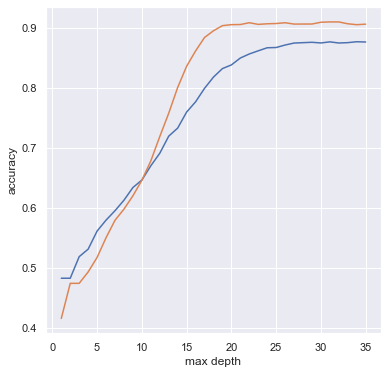

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# graph folder
os.chdir(r"C:\Users\Zack\Desktop\work\OSU\406 - p2 - learning\jupyter practice\final models\graphs")

#size 
sns.set(rc={'figure.figsize': (6, 6)})

print(max_depth)
# visualizing changes in parameters
sns.lineplot(x='max_depth', y='acc_gini', data=df)
sns.lineplot(x='max_depth', y='acc_entropy', data=df)
plt.xlabel('max depth')
plt.ylabel('accuracy')
# plt.xlim(1,30)
plt.savefig('gini vs entropy', bbox_inches = 'tight')
plt.show()

### Visualize training tree model

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# dot_data = StringIO()
# # number of unique values in target col
# class_names = list(tree_frame.categories.unique())

# # use trained decision tree model, feature columns, and clases in target col
# export_graphviz(dtc, out_file = dot_data, filled=True, rounded=True, special_characters=True,
#                 feature_names = features,
#                 class_names = class_names)

# # creates image and then displays in Jupyter
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('game_classes.png')
# Image(graph.create_png())